In [1]:
from os.path import join, dirname
from dotenv import load_dotenv
import os
from app.main import load_data
import streamlit as st
from snowflake import connector
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from scipy.optimize import curve_fit

pd.options.display.float_format = '{:,.2f}'.format

# get environment variables
dotenv_path = join(dirname('streamlit_grs_fit\\app\\'), '.env')
load_dotenv(dotenv_path)
SF_ACCOUNT = os.getenv('SF_ACCOUNT')
SF_USER = os.getenv('SF_USER')
SF_PASSWORD = os.getenv('SF_PASSWORD')
SF_ROLE = os.getenv('SF_ROLE')
SF_WAREHOUSE = os.getenv('SF_WAREHOUSE')
SF_DATABASE = os.getenv('SF_DATABASE')
SF_SCHEMA = os.getenv('SF_SCHEMA')

In [2]:
query = 'select '+\
            'job, gcs_cost, grs_cost, hoisting_cost, addons_cost, direct_cost, direct_labor_cost, total_cost '+\
            ',div0(gcs_cost, direct_cost) gcs_per_direct '+\
            ',div0(grs_cost, direct_cost) grs_per_direct '+\
            ',div0(direct_labor_cost, direct_cost) labor_per_direct '+\
            'from sandbox.public.gcs_fit ' +\
            'where gcs_cost > 0.1'
            # f'where div0(direct_cost, gcs_cost) >= {min_gcs_ratio} '+\
            # f'and div0(direct_cost, gcs_cost) <= {max_gcs_ratio} '+\
            # f'and div0(direct_cost, grs_cost) >= {min_grs_ratio} '+\
            # f'and div0(direct_cost, grs_cost) <= {max_grs_ratio} '+\
            # f'and total_cost >= {min_total_costs} '+\
            # f'and total_cost <= {max_total_costs} '+\
df_data = load_data(query).set_index('JOB') 
df_data = pd.DataFrame(df_data)

In [49]:
df_filtered = df_data.loc[
                    (0.01 < df_data.TOTAL_COST) &
                    (0.01 < df_data.GCS_PER_DIRECT) & (df_data.GCS_PER_DIRECT < 500000) &
                    (0.01 < df_data.GRS_PER_DIRECT) & (df_data.GRS_PER_DIRECT < 500000) &
                    (df_data.GRS_COST < (50_000 + df_data.DIRECT_COST / 7))&
                    (df_data.GCS_COST < (50_000 + df_data.DIRECT_COST)) &
                    (df_data.DIRECT_COST < 5_000_000)
]
df_filtered.describe()

,GCS_COST,GRS_COST,HOISTING_COST,ADDONS_COST,DIRECT_COST,DIRECT_LABOR_COST,TOTAL_COST,GCS_PER_DIRECT,GRS_PER_DIRECT,LABOR_PER_DIRECT
count,"2,196.00","2,196.00",132.00,"2,178.00","2,196.00","2,196.00","2,196.00","2,196.00","2,196.00","2,196.00"
mean,"32,928.02","18,109.95","10,021.52","20,934.78","299,408.58","16,646.76","371,812.08",0.73,0.83,0.20
std,"77,290.11","44,460.09","23,498.17","55,214.93","682,180.84","44,470.61","827,899.65",6.12,7.77,0.26
min,1.00,6.00,0.00,"-90,214.00",8.00,-39.00,164.00,0.01,0.01,-0.04
25%,942.00,691.50,258.25,804.00,"5,776.25",711.00,"10,732.50",0.07,0.04,0.03
50%,"5,667.00","3,202.00","1,638.00","3,608.50","35,662.50","3,269.50","55,400.50",0.12,0.07,0.08
75%,"27,873.00","15,782.00","6,884.50","17,130.25","228,603.25","13,876.25","294,742.00",0.26,0.17,0.25
max,"929,722.00","529,108.00","171,403.00","747,533.00","4,964,508.00","692,068.00","6,587,651.00",192.12,211.74,1.31


In [45]:
df_grs = pd.DataFrame()
df_grs['grs'] = df_filtered.GRS_COST
df_grs['direct_cost'] = df_filtered.DIRECT_COST
df_grs.describe()

,grs,direct_cost
count,"2,196.00","2,196.00"
mean,"18,109.95","299,408.58"
std,"44,460.09","682,180.84"
min,6.00,8.00
25%,691.50,"5,776.25"
50%,"3,202.00","35,662.50"
75%,"15,782.00","228,603.25"
max,"529,108.00","4,964,508.00"


In [46]:
df_gcs = pd.DataFrame()
df_gcs['gcs'] = df_filtered.GCS_COST
df_gcs['direct_cost'] = df_filtered.DIRECT_COST
df_gcs.describe()

,gcs,direct_cost
count,"2,196.00","2,196.00"
mean,"32,928.02","299,408.58"
std,"77,290.11","682,180.84"
min,1.00,8.00
25%,942.00,"5,776.25"
50%,"5,667.00","35,662.50"
75%,"27,873.00","228,603.25"
max,"929,722.00","4,964,508.00"


In [50]:
known_grs_costs = None
known_gcs_costs = None
def func(x, a, b, c): # x-shifted log
    return a*np.log(x + b)+c

def ModelAndScatterPlot(df, graphWidth, graphHeight, job_name, input_costs):
    feature_name = df.iloc[:,1:].columns[0].replace("_", " ").upper()
    target_name = df.iloc[:,0:1].columns[0].replace("_", " ").upper()
    xData = np.array(df.iloc[:,1])
    yData = np.array(df.iloc[:,0])

    # these are the same as the scipy defaults
    initialParameters = np.array([1.0, 1.0, 1.0])

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, xData, yData, initialParameters, maxfev=50000)
    modelPredictions = func(xData, *fittedParameters) 
    absError = modelPredictions - yData

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))

    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'o', alpha=0.3, label='actual data')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the upper bound
    axes.plot(xModel, yModel + RMSE, c='b', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} + σ')

    # now the model as a line plot
    axes.plot(xModel, yModel, c='g', linewidth=1, label=f'{target_name} ls regression')

    # now the lower bound
    axes.plot(xModel, yModel - RMSE, c='r', alpha=0.5, linestyle='--', linewidth=0.7, label=f'{target_name} - σ')

    # color +/- 1 std devialtion
    axes.fill_between(xModel, yModel + RMSE, yModel - RMSE, alpha=0.15)

    # now a test value
    prediction = fittedParameters[0] * np.log( input_costs + fittedParameters[1]) + fittedParameters[2]
    j, k = input_costs, prediction
    plt.text(0.1, 0.8, f'{job_name}: {feature_name} = ${input_costs:,.0f}',ha='left',va='top', weight='bold',transform = axes.transAxes)
    axes.scatter(j, k+RMSE, c='b', marker='D', label=f'{job_name}, {target_name} + σ')
    axes.annotate(f'{target_name} + σ = ${prediction+RMSE:,.0f}', (j+100, k+RMSE+100))
    axes.scatter(j, k, c='g', marker='D', label=f'{job_name} Predicted {target_name}')
    axes.annotate(f'Predicted {target_name} = ${prediction:,.0f}', (j+100, k+100))
    axes.scatter(j, k-RMSE, c='r', marker='D', label=f'{job_name}, {target_name} - σ')
    axes.annotate(f'{target_name} - σ = ${prediction-RMSE:,.0f}', (j+100, k-RMSE+100))

    #values if known
    if (target_name == 'GRS') & (known_grs_costs is not None):
        figure_check = f'Known {target_name} = ${known_grs_costs:,.0f}, prediction + {(known_grs_costs-prediction)/RMSE} * σ\n\n'
        h, i = input_costs, known_grs_costs
        axes.scatter(h, i, c='k', marker='D', label=f'{job_name} Known {target_name}')
    elif (target_name == 'GCS') & (known_gcs_costs is not None):
        figure_check = f'Known {target_name} = ${known_grs_costs:,.0f}, prediction + {(known_gcs_costs-prediction)/RMSE} * σ\n\n'
        o, p = input_costs, known_gcs_costs
        axes.scatter(o, p, c='k', marker='D', label=f'{job_name} Known {target_name}')
    else:
        figure_check = '\n'


    # labels and stuff
    axes.set_xlabel(feature_name)
    axes.set_ylabel(target_name)
    fmt = '${x:,.0f}'
    tick = StrMethodFormatter(fmt)
    axes.xaxis.set_major_formatter(tick)
    axes.yaxis.set_major_formatter(tick)
    axes.legend(loc='lower right')

    details = f'{job_name}: {feature_name} = ${input_costs:,.0f}, Predicted {target_name}: ${prediction:,.0f}\n'+\
                        f'{figure_check}'+\
                        f'Parameters: {fittedParameters}\n'+\
                        f'Function:  {fittedParameters[0]} * ln( x + {fittedParameters[1]}) + {fittedParameters[2]}\n'+\
                        f'RMSE: {RMSE}\n'+\
                        f'R-squared: {Rsquared}'
    
    return f, details, prediction

SMC Edmonds CC: DIRECT COST = $400,000, Predicted GRS: $23,950
Known GRS = $80,000, prediction + 2.0618251892078012 * σ

Parameters: [  1489678.55869582  27336101.51529863 -25506526.7341805 ]
Function:  1489678.5586958206 * ln( x + 27336101.515298635) + -25506526.7341805
RMSE: 27184.646450817167
R-squared: 0.6259716303916267


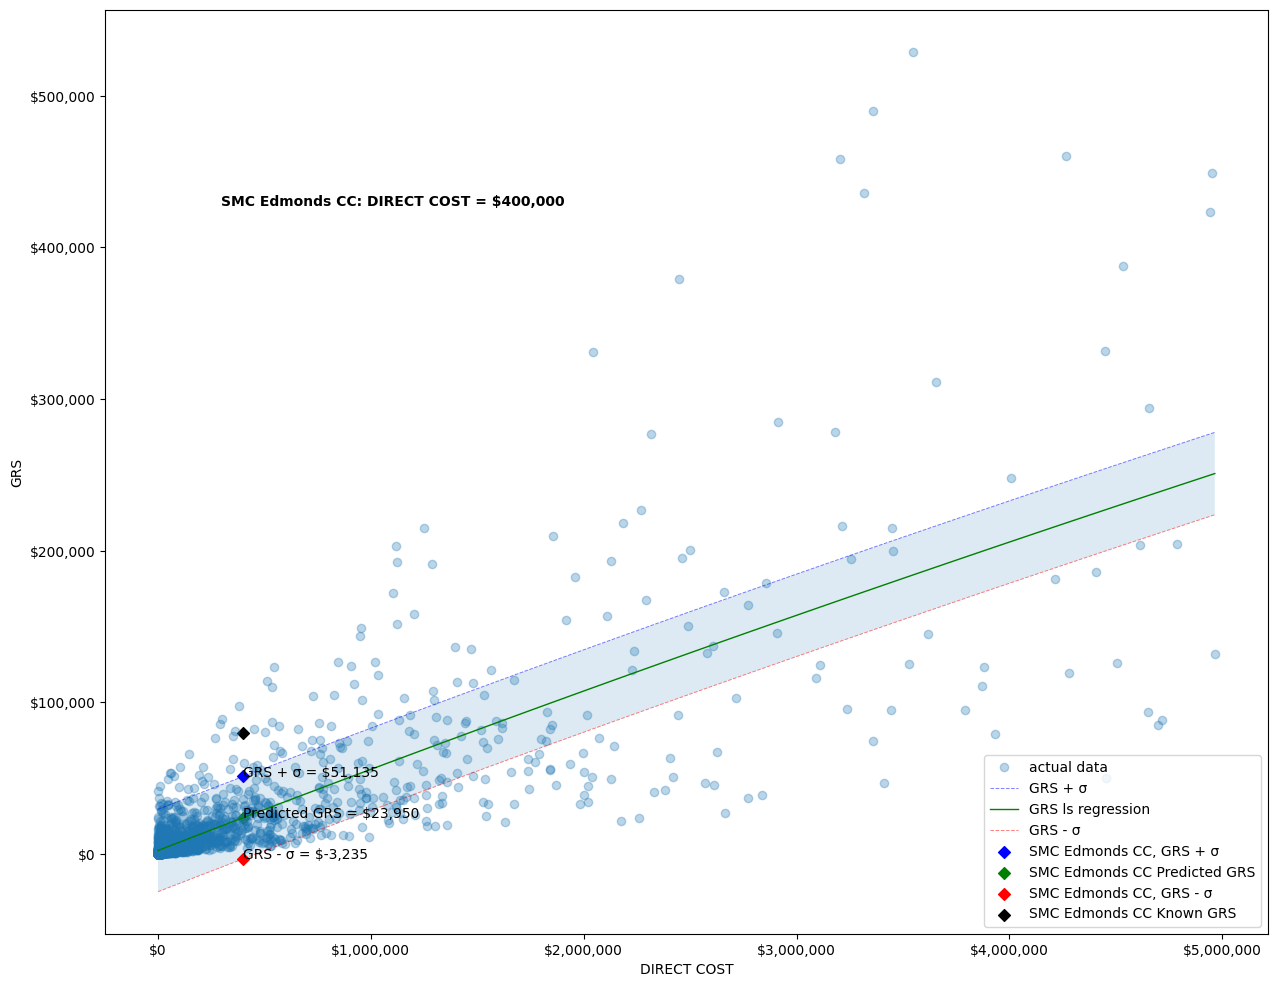

In [52]:
known_grs_costs = 80000
known_gcs_costs = 60000
graphWidth = 1500
graphHeight = graphWidth * 800 / 1000
f, details, grs_prediction = ModelAndScatterPlot(df_grs, graphWidth, graphHeight, 'SMC Edmonds CC', 400_000)
f.show()
print(details)

SMC Edmonds CC: DIRECT COST = $400,000, Predicted GCS: $46,799
Known GCS = $30,000, prediction + 0.28688159421536624 * σ

Parameters: [   673923.12671776   5990841.47625031 -10513830.48127302]
Function:  673923.1267177577 * ln( x + 5990841.47625031) + -10513830.48127302
RMSE: 46016.72273956248
R-squared: 0.6453652200067512


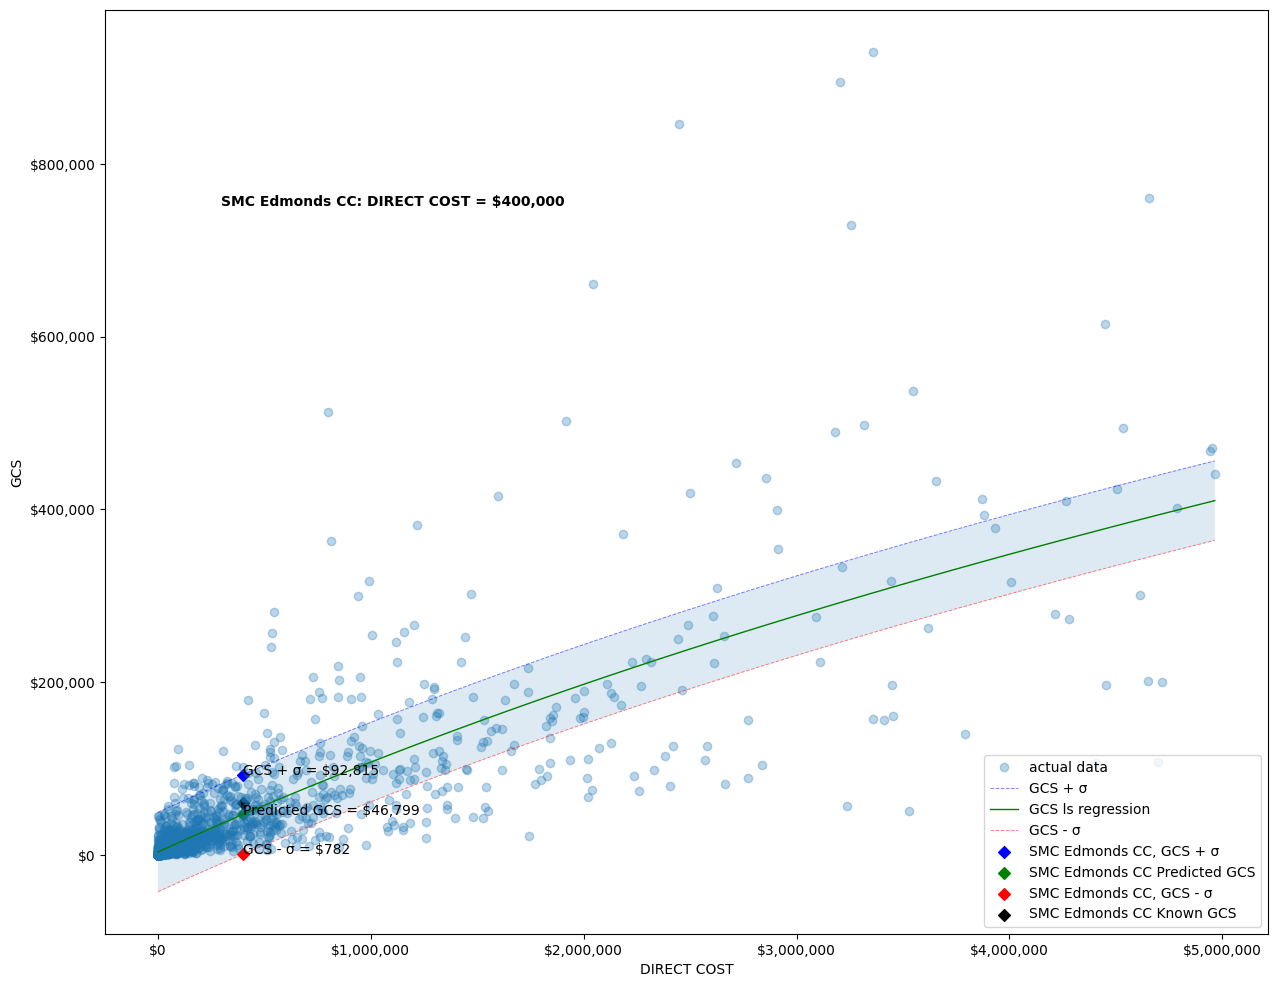

In [53]:
known_grs_costs = 30000
known_gcs_costs = 60000
graphWidth = 1500
graphHeight = graphWidth * 800 / 1000
f, details, grs_prediction = ModelAndScatterPlot(df_gcs, graphWidth, graphHeight, 'SMC Edmonds CC', 400_000)
f.show()
print(details)